## Genetic Drift in Sibling Mating: A Markov Chain Model

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from collections import defaultdict

# Define genotype states
states = ["aa,aa", "aa,ab", "aa,bb", "ab,ab", "ab,bb", "bb,bb"]
absorbing_states = ["aa,aa", "bb,bb"]
transient_states = [s for s in states if s not in absorbing_states]

# Function to get allele combinations for each genotype
def alleles(geno):
    return {"aa": ["a", "a"], "bb": ["b", "b"], "ab": ["a", "b"]}[geno]

# Function to get child genotype distribution
def offspring_distribution(parent1, parent2):
    a1 = alleles(parent1)
    a2 = alleles(parent2)
    children = []
    for x in a1:
        for y in a2:
            children.append("".join(sorted([x, y])))
    probs = defaultdict(int)
    for child in children:
        probs[child] += 1
    total = len(children)
    for key in probs:
        probs[key] /= total
    return probs

# Given parent genotypes, compute next-gen pair probabilities
def next_generation_distribution(p1, p2):
    child_probs = offspring_distribution(p1, p2)
    genotypes = list(child_probs.keys())
    pair_probs = defaultdict(float)
    for g1 in genotypes:
        for g2 in genotypes:
            prob = child_probs[g1] * child_probs[g2]
            pair = ",".join(sorted([g1, g2]))
            pair_probs[pair] += prob
    return pair_probs

# Define parent genotype mappings
parent_pairs = {
    "aa,aa": ("aa", "aa"),
    "aa,ab": ("aa", "ab"),
    "aa,bb": ("aa", "bb"),
    "ab,ab": ("ab", "ab"),
    "ab,bb": ("ab", "bb"),
    "bb,bb": ("bb", "bb")
}

# Build transition matrix
transition_matrix = pd.DataFrame(0.0, index=states, columns=states)
for state in states:
    p1, p2 = parent_pairs[state]
    new_gen = next_generation_distribution(p1, p2)
    for pair, prob in new_gen.items():
        if pair in transition_matrix.columns:
            transition_matrix.loc[state, pair] += prob

# Create Q and R matrices
Q = transition_matrix.loc[transient_states, transient_states]
R = transition_matrix.loc[transient_states, absorbing_states]

# Fundamental matrix N = (I - Q)^-1
I = np.eye(len(Q))
N = np.linalg.inv(I - Q.values)
N_df = pd.DataFrame(N, index=Q.index, columns=Q.columns)

# Expected steps to absorption
expected_steps = N.sum(axis=1)
expected_steps_df = pd.DataFrame(expected_steps, index=Q.index, columns=["Expected Steps"])

# Absorption probabilities
B = N @ R.values
B_df = pd.DataFrame(B, index=Q.index, columns=R.columns)

# Print all results
print("===== Transition Matrix =====")
print(transition_matrix.round(4))

print("\n===== Fundamental Matrix (N) =====")
print(N_df.round(4))

print("\n===== Expected Steps to Absorption =====")
print(expected_steps_df.round(4))

print("\n===== Absorption Probabilities =====")
print(B_df.round(4))

===== Transition Matrix =====
        aa,aa  aa,ab  aa,bb  ab,ab  ab,bb   bb,bb
aa,aa  1.0000   0.00  0.000   0.00   0.00  0.0000
aa,ab  0.2500   0.50  0.000   0.25   0.00  0.0000
aa,bb  0.0000   0.00  0.000   1.00   0.00  0.0000
ab,ab  0.0625   0.25  0.125   0.25   0.25  0.0625
ab,bb  0.0000   0.00  0.000   0.25   0.50  0.2500
bb,bb  0.0000   0.00  0.000   0.00   0.00  1.0000

===== Fundamental Matrix (N) =====
        aa,ab   aa,bb   ab,ab   ab,bb
aa,ab  2.6667  0.1667  1.3333  0.6667
aa,bb  1.3333  1.3333  2.6667  1.3333
ab,ab  1.3333  0.3333  2.6667  1.3333
ab,bb  0.6667  0.1667  1.3333  2.6667

===== Expected Steps to Absorption =====
       Expected Steps
aa,ab          4.8333
aa,bb          6.6667
ab,ab          5.6667
ab,bb          4.8333

===== Absorption Probabilities =====
       aa,aa  bb,bb
aa,ab   0.75   0.25
aa,bb   0.50   0.50
ab,ab   0.50   0.50
ab,bb   0.25   0.75


## Graph Visualization

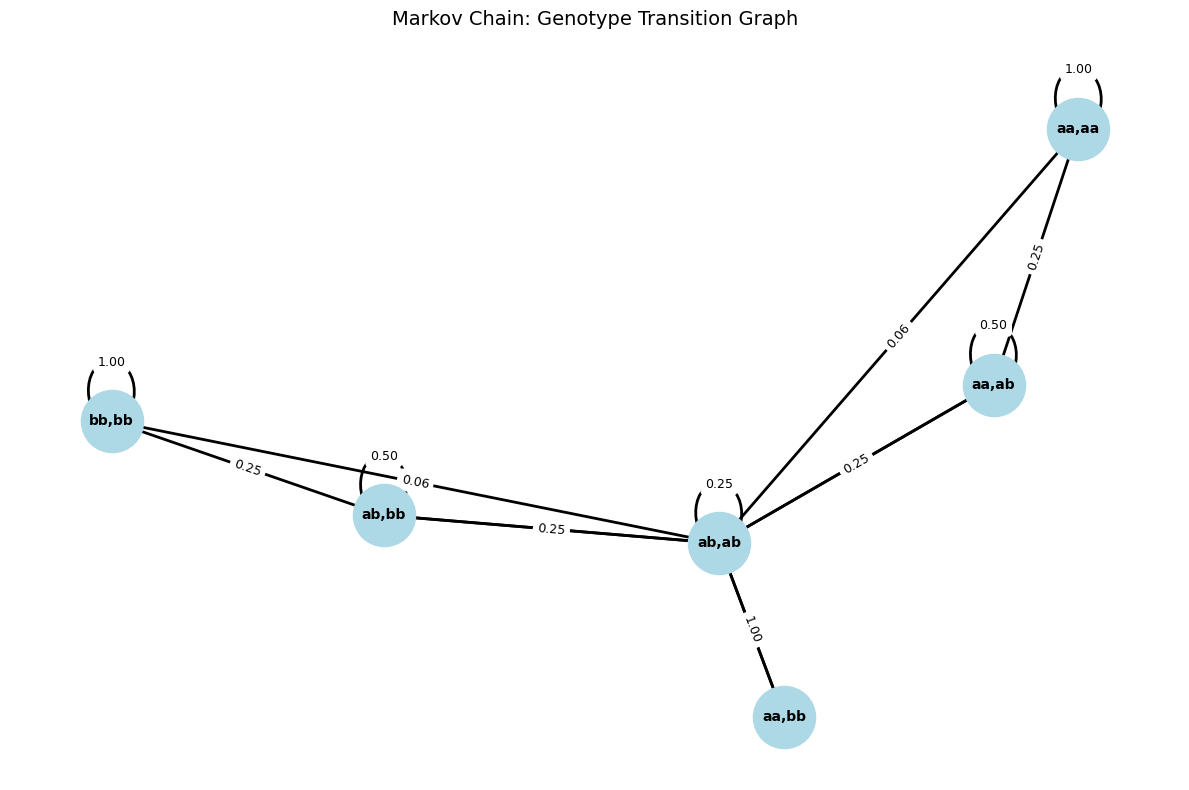

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add edges from the transition matrix
for from_state in transition_matrix.index:
    for to_state in transition_matrix.columns:
        prob = transition_matrix.loc[from_state, to_state]
        if prob > 0.01:  # skip very small transitions for clarity
            G.add_edge(from_state, to_state, weight=prob)

# Draw the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, width=2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Add edge labels with probabilities
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Markov Chain: Genotype Transition Graph", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()